In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# mount ggdrive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/Mr.Dat/

/content/drive/My Drive/Mr.Dat


In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load traindf

In [0]:
df = pd.read_csv('data/train_df.csv')

In [0]:
# split train val
train_df, val_df = train_test_split(df ,test_size=0.2, random_state=0, stratify=df['binaray_return_next10days'])

In [0]:
train_indices = train_df.index.values
val_indices = val_df.index.values

In [0]:
train_indices

array([1318856, 1279718, 1397903, ...,  898869,  664293,  280221])

In [0]:
cat_cols = ['assetCode']

num_cols = [c for c in df.columns if c not in ['assetCode', 'time', 'returnsOpenNextMktres10',
                                                         'date', 'binaray_return_next10days']] 

In [0]:
df[num_cols].shape

(1616666, 51)

# prepare for NN model

In [0]:
def encode(encoder, x):
    len_encoder = len(encoder)
    try:
        id = encoder[x]
    except KeyError:
        id = len_encoder
    return id

In [0]:
encoders = [{} for cat in cat_cols]

for i, cat in enumerate(cat_cols):
    print('encoding %s ...' % cat, end=' ')
    encoders[i] = {l: id for id, l in enumerate(df.loc[train_indices, cat].astype(str).unique())}
    df[cat] = df[cat].astype(str).apply(lambda x: encode(encoders[i], x))
    print('Done')

encoding assetCode ... Done


In [0]:
embed_sizes = [len(encoder) + 1 for encoder in encoders] #+1 for possible unknown assets

In [0]:
from sklearn.preprocessing import StandardScaler
 
print('scaling numerical columns')

scaler = StandardScaler()

df[num_cols] = scaler.fit_transform(df[num_cols])

scaling numerical columns


In [0]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization
from keras.losses import binary_crossentropy, mse

Using TensorFlow backend.


In [0]:
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply

import keras
from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD

In [0]:
categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[1], name=cat))

categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

#  NN model

In [0]:
#categorical_logits = Concatenate()([Flatten()(cat_emb) for cat_emb in categorical_embeddings])
categorical_logits = Flatten()(categorical_embeddings[0])
categorical_logits = Dense(32,activation='relu')(categorical_logits)
categorical_logits = Dropout(0.5)(categorical_logits)
categorical_logits = BatchNormalization()(categorical_logits)
categorical_logits = Dense(32,activation='relu')(categorical_logits)

numerical_inputs = Input(shape=(51,), name='num')
numerical_logits = numerical_inputs
numerical_logits = BatchNormalization()(numerical_logits)

numerical_logits = Dense(128,activation='relu')(numerical_logits)
numerical_logits = Dropout(0.5)(numerical_logits)
numerical_logits = BatchNormalization()(numerical_logits)
numerical_logits = Dense(128,activation='relu')(numerical_logits)
numerical_logits = Dense(64,activation='relu')(numerical_logits)

logits = Concatenate()([numerical_logits,categorical_logits])
logits = Dense(64,activation='relu')(logits)
out = Dense(1, activation='sigmoid')(logits)

model = Model(inputs = categorical_inputs + [numerical_inputs], outputs=out)
model.compile(optimizer='adam',loss=binary_crossentropy)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def get_input_NN(market_train, indices):
    X_num = market_train.loc[indices, num_cols].values
    X = {'num':X_num}
    for cat in cat_cols:
        X[cat] = market_train.loc[indices, cat_cols].values
    y = (market_train.loc[indices,'returnsOpenNextMktres10'] >= 0).values
    r = market_train.loc[indices,'returnsOpenNextMktres10'].values
    # u = market_train.loc[indices, 'universe']
    d = market_train.loc[indices, 'time'].dt.date
    return X,y,r,d

In [0]:
df.head(1)

,returnsClosePrevRaw10,returnsClosePrevMktres10,close,assetCode,month,close_ma14,close_ma200,close_ma30,volume,close_ma50,returnsClosePrevMktres1,returnsClosePrevRaw1,returnsOpenPrevRaw1,vol_pct_10,day,quarter,time,mom1,mom2,mom3,mom4,mom5,mom10,volatility_50,volatility_31,volatility_15,returnsOpenNextMktres10,date,sourceId_mean,urgency_mean,takeSequence_mean,provider_mean,bodySize_mean,companyCount_mean,headlineTag_mean,marketCommentary_mean,sentenceCount_mean,wordCount_mean,firstMentionSentence_mean,relevance_mean,sentimentClass_mean,sentimentNegative_mean,sentimentNeutral_mean,sentimentPositive_mean,sentimentWordCount_mean,noveltyCount12H_mean,noveltyCount24H_mean,noveltyCount3D_mean,noveltyCount5D_mean,noveltyCount7D_mean,volumeCounts12H_mean,volumeCounts24H_mean,volumeCounts3D_mean,volumeCounts5D_mean,volumeCounts7D_mean,binaray_return_next10days
0,-1.678704,-0.091687,-0.414824,1548,1.266603,-0.370349,-0.321267,-0.340451,-0.299967,-0.31206,2.061831,3.540499,-0.005156,-0.004122,1.416201,1.306291,2008-11-21 22:00:00+00:00,3.135108,1.070275,-0.696409,-0.862661,-0.590514,-1.500523,1.215905,1.433635,1.268212,-0.01048,2008-11-21,0.025231,0.34303,-0.175877,-0.19444,-0.123699,-0.19667,-0.257741,-0.147062,-0.447393,-0.452786,-0.278451,-0.631084,-0.150423,-0.186946,-0.093147,-0.075628,-0.168561,-0.252412,-0.232637,-0.13469,-0.110476,-0.093642,-0.192381,-0.172545,-0.186148,-0.183155,-0.184587,False


In [0]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')

In [0]:
X_train,y_train,r_train,d_train = get_input_NN(df, train_indices)
X_valid,y_valid,r_valid,d_valid = get_input_NN(df, val_indices) 

In [0]:
# https://www.kaggle.com/guowenrui/market-nn-if-you-like-you-can-use-it-and-upvote
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')
        
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("model.hdf5",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

check_point = ModelCheckpoint('models/nn_model.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)
model.fit(X_train,y_train.astype(int),
          validation_data=(X_valid,y_valid.astype(int)),
          epochs=50,
          verbose=True,
          callbacks=[early_stop,check_point]) 




Train on 1293332 samples, validate on 323334 samples
Epoch 1/50





1293332/1293332 [==============================] - 358s 277us/step - loss: 0.6875 - val_loss: 0.6849

Epoch 00001: val_loss improved from inf to 0.68487, saving model to model.hdf5
Epoch 2/50
1293332/1293332 [==============================] - 350s 270us/step - loss: 0.6848 - val_loss: 0.6852

Epoch 00002: val_loss did not improve from 0.68487
Epoch 3/50
1293332/1293332 [==============================] - 353s 273us/step - loss: 0.6839 - val_loss: 0.6843

Epoch 00003: val_loss improved from 0.68487 to 0.68429, saving model to model.hdf5
Epoch 4/50
1293332/1293332 [==============================] - 347s 269us/step - loss: 0.6836 - val_loss: 0.6830

Epoch 00004: val_loss improved from 0.68429 to 0.68301, saving model to model.hdf5
Epoch 5/50
1293332/1293332 [==============================] - 352s 272us/step - loss: 0.6833 - val_loss: 0.6834

Epoch 00005: val_loss did not improve from 0.68301
Epoch 6/50
1293332/1293332 

In [0]:
confidence_train = model.predict(X_train)[:,0]*2 -1
print(accuracy_score(confidence_train>0,y_train))

0.5647281595135665


In [0]:
# calculation of actual metric that is used to calculate final score
r_train = r_train.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_train * r_train
data = {'day' : d_train, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_train = mean / std
print(score_train)

0.636767474508515


In [0]:
del data
del df
del x_t
del mean
del std

In [0]:
confidence_valid = model.predict(X_valid)[:,0]*2 -1
print(accuracy_score(confidence_valid>0,y_valid))

0.5607699777938602


In [0]:
# calculation of actual metric that is used to calculate final score
r_valid = r_valid.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_valid * r_valid
data = {'day' : d_valid, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

0.5352121442981461


# lgb

In [0]:
def get_input_lgb(df):
    X = df[num_cols].values
    y = df.binaray_return_next10days.values
    r = df.returnsOpenNextMktres10.values
    d = df.time.dt.date
    return X,y,r,d

In [0]:
train_df['time'] = pd.to_datetime(train_df['time'], errors='coerce')
val_df['time'] = pd.to_datetime(val_df['time'], errors='coerce')

In [0]:
X_train,y_train,r_train,d_train = get_input_lgb(train_df)
X_valid,y_valid,r_valid,d_valid = get_input_lgb(val_df) 

In [0]:
import lightgbm as lgb
x_1 = [0.07, 2000, 212, 100, 202]
x_2 = [0.1, 2400, 213, 100, 220]

params_1 = {
        'task': 'train',
        'boosting_type': 'dart',
        'objective': 'binary',
        'n_estimators': 500,
        'learning_rate': x_1[0],
        'num_leaves': x_1[1],
        'min_data_in_leaf': x_1[2],
        'num_iteration': x_1[3],
        'max_bin': x_1[4],
        'reg_alpha' : 0.01,
        'reg_lambda' : 0.01,
        'verbose': 1
    }

params_2 = {
        'task': 'train',
        'boosting_type': 'dart',
        'n_estimators': 500,
        'objective': 'binary',
        'learning_rate': x_2[0],
        'num_leaves': x_2[1],
        'min_data_in_leaf': x_2[2],
        'num_iteration': x_2[3],
        'max_bin': x_2[4],
        'reg_alpha' : 0.01,
        'reg_lambda' : 0.01,
        'verbose': 1
    }

In [0]:
lgb1 = lgb.train(params_1, train_set=lgb.Dataset(X_train, label=y_train), num_boost_round=120,
                  valid_sets=lgb.Dataset(X_valid, label=y_valid),
                  verbose_eval=10, early_stopping_rounds=5)

lgb2 = lgb.train(params_2, train_set=lgb.Dataset(X_train, label=y_train), num_boost_round=120,
                  valid_sets=lgb.Dataset(X_valid, label=y_valid),
                  verbose_eval=10, early_stopping_rounds=5)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[10]	valid_0's binary_logloss: 0.684817
[20]	valid_0's binary_logloss: 0.680775
[30]	valid_0's binary_logloss: 0.678068
[40]	valid_0's binary_logloss: 0.676325
[50]	valid_0's binary_logloss: 0.675907
[60]	valid_0's binary_logloss: 0.67523
[70]	valid_0's binary_logloss: 0.674561
[80]	valid_0's binary_logloss: 0.673882
[90]	valid_0's binary_logloss: 0.673976
[100]	valid_0's binary_logloss: 0.67347
[10]	valid_0's binary_logloss: 0.682739
[20]	valid_0's binary_logloss: 0.678013
[30]	valid_0's binary_logloss: 0.674409
[40]	valid_0's binary_logloss: 0.672407
[50]	valid_0's binary_logloss: 0.671942
[60]	valid_0's binary_logloss: 0.670743
[70]	valid_0's binary_logloss: 0.670287
[80]	valid_0's binary_logloss: 0.669465
[90]	valid_0's binary_logloss: 0.669459
[100]	valid_0's binary_logloss: 0.668789


# saving lgb

In [0]:
lgb1.save_model('models/lgb1.txt')
lgb2.save_model('models/lgb2.txt')

# Result on Training data

In [0]:
import matplotlib.pyplot as plt

0.6934862819446206


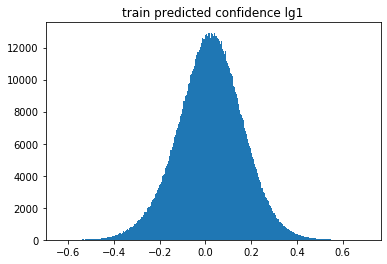

In [0]:
# distribution of confidence that will be used as submission
confidence_train_lgb1= lgb1.predict(X_train)*2 -1
print(accuracy_score(confidence_train_lgb1>0,y_train))
plt.hist(confidence_train_lgb1, bins='auto')
plt.title("train predicted confidence lg1")
plt.show()

0.74254019849505


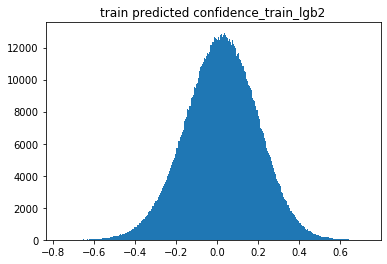

In [0]:
# distribution of confidence that will be used as submission
confidence_train_lgb2= lgb2.predict(X_train)*2 -1
print(accuracy_score(confidence_train_lgb2>0,y_train))
plt.hist(confidence_train_lgb2, bins='auto')
plt.title("train predicted confidence_train_lgb2")
plt.show()

In [0]:
# calculation of actual metric that is used to calculate final score
r_train = r_train.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_train_lgb1 * r_train
data = {'day' : d_train, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_train = mean / std
print(score_train)

1.4685830548680001


0.5810585957554727


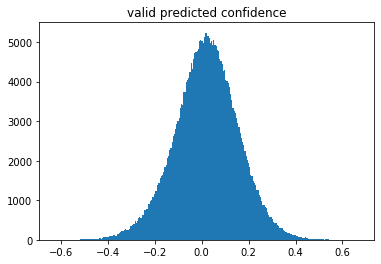

In [0]:
# distribution of confidence that will be used as submission
confidence_valid= lgb1.predict(X_valid)*2 -1
print(accuracy_score(confidence_valid>0,y_valid))
plt.hist(confidence_valid, bins='auto')
plt.title("valid predicted confidence")
plt.show()

In [0]:
# calculation of actual metric that is used to calculate final score
r_valid = r_valid.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_valid * r_valid
data = {'day' : d_valid, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

0.8322760093328778
